In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *
from src.plotting import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple
import wandb 
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

In [4]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.05, 
    "e_n":0.005, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 200,
    "node_multiplier": 10,
    "min_error": 5
}

In [5]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/500, Reward -1000.0, Average Max Reward: -1000.0, Total steps 1000.0, Epsilon: 0.72, Alpha: 0.10, Time 0.097
Episode 100/500, Reward -1000.0, Average Max Reward: -750.4, Total steps 1000.0, Epsilon: 0.54, Alpha: 0.10, Time 0.095
Episode 150/500, Reward -895.0, Average Max Reward: -635.1, Total steps 895.0, Epsilon: 0.37, Alpha: 0.10, Time 0.093
Episode 200/500, Reward -257.0, Average Max Reward: -268.2, Total steps 257.0, Epsilon: 0.19, Alpha: 0.10, Time 0.033
Episode 250/500, Reward -235.0, Average Max Reward: -484.7, Total steps 235.0, Epsilon: 0.01, Alpha: 0.10, Time 0.028
Episode 300/500, Reward -171.0, Average Max Reward: -368.6, Total steps 171.0, Epsilon: 0.01, Alpha: 0.10, Time 0.029
Episode 350/500, Reward -1000.0, Average Max Reward: -492.8, Total steps 1000.0, Epsilon: 0.01, Alpha: 0.10, Time 0.137
Episode 400/500, Reward -159.0, Average Max Reward: -190.3, Total steps 159.0, Epsilon: 0.01, Alpha: 0.10, Time 0.018
Episode 450/500, Reward -257.0, Average Max Reward

In [17]:
def run_experiments(num_experiments=10):
    experiments = []

    for i in range(num_experiments):
        stats_q_acc =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

        stats = {
                "step":  np.zeros(num_episodes),
                "cumulative_reward":  np.zeros(num_episodes),
                "selector":    np.zeros(num_episodes),
                "global_error":     np.zeros((num_episodes, env.action_space.n)),
                "mlgng_nodes":      [],
                "best_actions":     [],
                "nodes": np.zeros((num_episodes, env.action_space.n)),
                "rate": np.zeros(num_episodes),
                "max_avg_reward": np.zeros(num_episodes),
        }

        conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
        support = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)
        conrl.init_support(support)
        conrl.init_mlgng(**mlgng_params)

        print("#### Starting training #####")
        print_freq=50
        conrl.rewards = stats["cumulative_reward"]
        conrl.max_avg_reward = np.NINF

        conrl.init_adaptive_lr_params()
        
        for episode in range(num_episodes):
            conrl.episode = episode
            done = False
            step = 0
            cumulative_reward = 0
            selector_sequence = []

            start = time.time()
            state = env.reset()

            while not done:
                next_state, reward, done, selected = conrl.step(state, env)
                state = next_state
                
                cumulative_reward += reward
                selector_sequence.append(selected)
                step+=1

            stats["selector"][episode] = sum(selector_sequence)/len(selector_sequence)
            stats["cumulative_reward"][episode] = cumulative_reward
            stats["step"][episode] = step 
            stats["global_error"][episode] = conrl.mlgng.get_last_stat_tuple("global_error")
            stats["best_actions"].append(conrl.get_best_actions())
            stats["mlgng_nodes"].append(conrl.mlgng.get_nodes())
            stats["nodes"][episode] = conrl.mlgng.get_last_stat_tuple("vertices")
            stats["rate"][episode] = conrl.discount_selector()

            conrl.update_lr(episode)
            conrl.decay_param("discount", episode, decay_rate=0.015)
            conrl.support.epsilon = conrl.discount

            if conrl.episode >= 10:
                lower_window = conrl.episode-10
            else:
                lower_window = 0
            
            mean_reward = conrl.rewards[lower_window:conrl.episode].mean()
            if mean_reward > conrl.max_avg_reward:
                conrl.max_avg_reward = mean_reward
            
            stats["max_avg_reward"][episode] = conrl.max_avg_reward

            conrl.support.evaluate(env=env, stats=stats_q_acc, episode=episode)

            if (episode+1) % print_freq == 0:
                end = time.time() - start
                print("Episode {}/{}, Average Max Reward: {:.2f}, Global Error: {:.2f}, Total steps {}, Discount: {:.2f}, Time {:.3f}".format(
                    episode+1, 
                    num_episodes, 
                    stats["cumulative_reward"][episode-print_freq+1:episode].mean(),
                    stats["global_error"][episode].sum(),
                    stats["step"][episode], 
                    stats["rate"][episode], 
                    end))
                conrl.mlgng.print_stats(one_line=True)
        experiments.append(stats_q_acc)
        print("\n\n#### Finished experiment {}/{} in {:.2f} min\n\n".format(i+1, num_experiments, (end-start)/60))
                

In [18]:
def log_stats_to_wandb(experiments, group):

    for stats in experiments:
        run = wandb.init(
            entity="dodicin",
            project="con-rl",
            group=group,
            notes="testing features",
            tags=[group],
            config={"q_params": q_params,
                    "mlgng_params": mlgng_params})

        for episode in range(num_episodes):
            wandb.log({
                    'cumulative_reward': stats["cumulative_reward"][episode], 
                    'steps': stats["step"][episode],
                    'selector': stats["selector"][episode],
                    'global_error': {key: value for key, value in enumerate(stats["global_error"][episode])},
                    'nodes_per_layer': {key: value for key, value in enumerate(stats["nodes"][episode])},
                    'total_nodes': np.sum(stats["nodes"][episode]),
                    'global_mean_error': np.mean(stats["global_error"][episode])
                    })

        run.finish()

In [19]:
experiments = run_experiments(10)



#### Finished experiment 3/10 in -26799159.84 min


#### Starting training #####
#### QL: Episode 50, Reward -1000.0, Average Max Reward: -927.6, Total steps 1000.0, Epsilon: 0.48, Alpha: 0.10, Time 0.121
Episode 50/500, Average Max Reward: -917.43, Global Error: 25.51, Total steps 295.0, Discount: 0.04, Time 0.437
	 MLGNG nodes per action layer: 2 2 2
#### QL: Episode 100, Reward -1000.0, Average Max Reward: -779.7, Total steps 1000.0, Epsilon: 0.22, Alpha: 0.10, Time 0.123
Episode 100/500, Average Max Reward: -775.41, Global Error: 89.09, Total steps 248.0, Discount: 0.18, Time 0.401
	 MLGNG nodes per action layer: 4 3 7
#### QL: Episode 150, Reward -228.0, Average Max Reward: -756.0, Total steps 228.0, Epsilon: 0.10, Alpha: 0.10, Time 0.029
Episode 150/500, Average Max Reward: -246.73, Global Error: 89.87, Total steps 271.0, Discount: 0.02, Time 0.336
	 MLGNG nodes per action layer: 5 4 6
#### QL: Episode 200, Reward -1000.0, Average Max Reward: -1000.0, Total steps 1000.0, Epsilo

In [21]:
wandb.login()
log_stats_to_wandb(experiments, group="ql-accelleration")

TypeError: 'NoneType' object is not iterable

In [23]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))

act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255

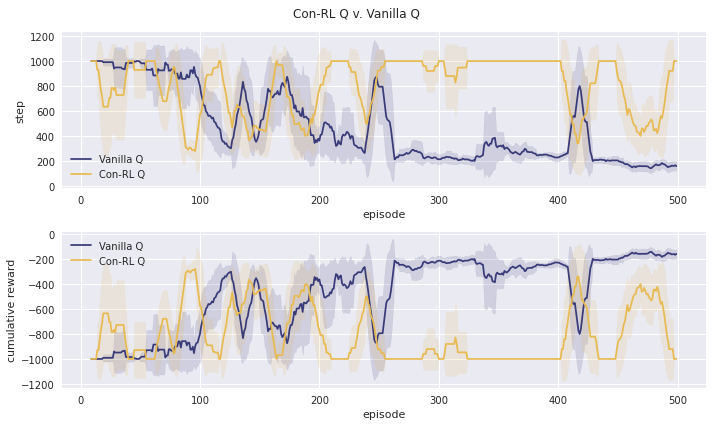

In [28]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL Q": {key: value for key, value in stats_q_acc.items() if key in to_plot}
},
title="Con-RL Q v. Vanilla Q",
rolling_window=10)

In [ ]:
to_plot = ["cumulative_reward", "rate", "max_avg_reward", "global_error"]

stats_to_plot = {key: value for key, value in stats.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
# stats_to_plot["nodes"] = stats_to_plot["nodes"].sum(axis=1)

plot_stats(stats_to_plot, figsize=(10, 8), title="Con-RL performance in Mountain-Car")

In [ ]:
plot_nodes_changes(stats["mlgng_nodes"], 
                rewards=stats["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)

In [ ]:
plot_nodes_changes(stats["mlgng_nodes"], 
                rewards=stats["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)

In [ ]:
with (open("./src/experiments/base.p", "rb")) as openfile:
    base_exp = pickle.load(openfile)

with (open("./src/experiments/node_perturbed_addition.p", "rb")) as openfile:
    perturbed_exp = pickle.load(openfile)

In [ ]:
plot_nodes_changes(base_exp[0]["mlgng_nodes"], 
                rewards=base_exp[0]["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(perturbed_exp[0]["mlgng_nodes"], 
                rewards=perturbed_exp[0]["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)

In [ ]:
# to_plot = ["step", "cumulative_reward"]
# plot_stats_comparison({
#     "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
#     "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
# },
# title="Con-RL v. Vanilla Q",
# rolling_window=10)